# Image classification with TensorFlow
```{eval-rst}
Last updated |lastupdate|
```

[![Open in Colab](https://img.shields.io/static/v1?logo=google-colab&message=Open%20in%20colab&color=blue&label=%20&labelColor=5c5c5c)](https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/tf-classifier.ipynb)

In this notebook we will revisit the image classification problem with TensorFLow. You will see how to create models and how to access the machinery of stochastic gradient descent using the existing software tooling.

## Load packages 
In this cell, we will load the python packages we need for this notebook

In [1]:
import imageio
import skimage
import sklearn.model_selection
import skimage.color
import skimage.transform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import tensorflow_addons as tfa
import os
import deepcell

## The supervised machine learning workflow
Recall the workflow outlined in the linear classifier notebook
- Create a training dataset
- Specify a model
- Specify a loss function, optimization algorithm, and training parameters
- Train the model 
- Benchmark the model
We will implement these steps using TensorFlow in this notebook

## Create training data
We will reuse our toy example of building a classifier that can distinguish cats from dogs.

In [2]:
# Download the training dataset from the cloud bucket
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNEL = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Load the training dataset into memory
def load_training_data(direc, n_cat_images=4096, n_dog_images=4096):
    filenames = os.listdir(direc)
    
    imgs = []
    labels = []
    
    cat_counter = 0
    dog_counter = 0
    for filename in filenames:
        fullpath = os.path.join(direc, filename)
        category = filename.split('.')[0]

        if category == "dog" and dog_counter < n_dog_images:
            labels.append(0)
            img = imageio.imread(fullpath)
            img = skimage.transform.resize(img, IMG_SIZE)
            img = skimage.exposure.equalize_adapthist(img)
            img = skimage.exposure.rescale_intensity(img, out_range=(0,1))
            imgs.append(img)
            dog_counter += 1
            
        elif category == "cat" and cat_counter < n_cat_images:
            labels.append(1)
            img = imageio.imread(fullpath)
            img = skimage.transform.resize(img, IMG_SIZE)
            img = skimage.exposure.equalize_adapthist(img)
            img = skimage.exposure.rescale_intensity(img, out_range=(0,1))
            imgs.append(img)
            cat_counter += 1

    X = np.stack(imgs, axis=0)
    y = np.array(labels)
    
    # Randomly shuffle
    index = np.arange(n_cat_images + n_dog_images)
    np.random.shuffle(index)
    X = X[index]
    y = y[index]
    
    return X, y
        
X, y = load_training_data('/data/bebi205/cats_and_dogs')

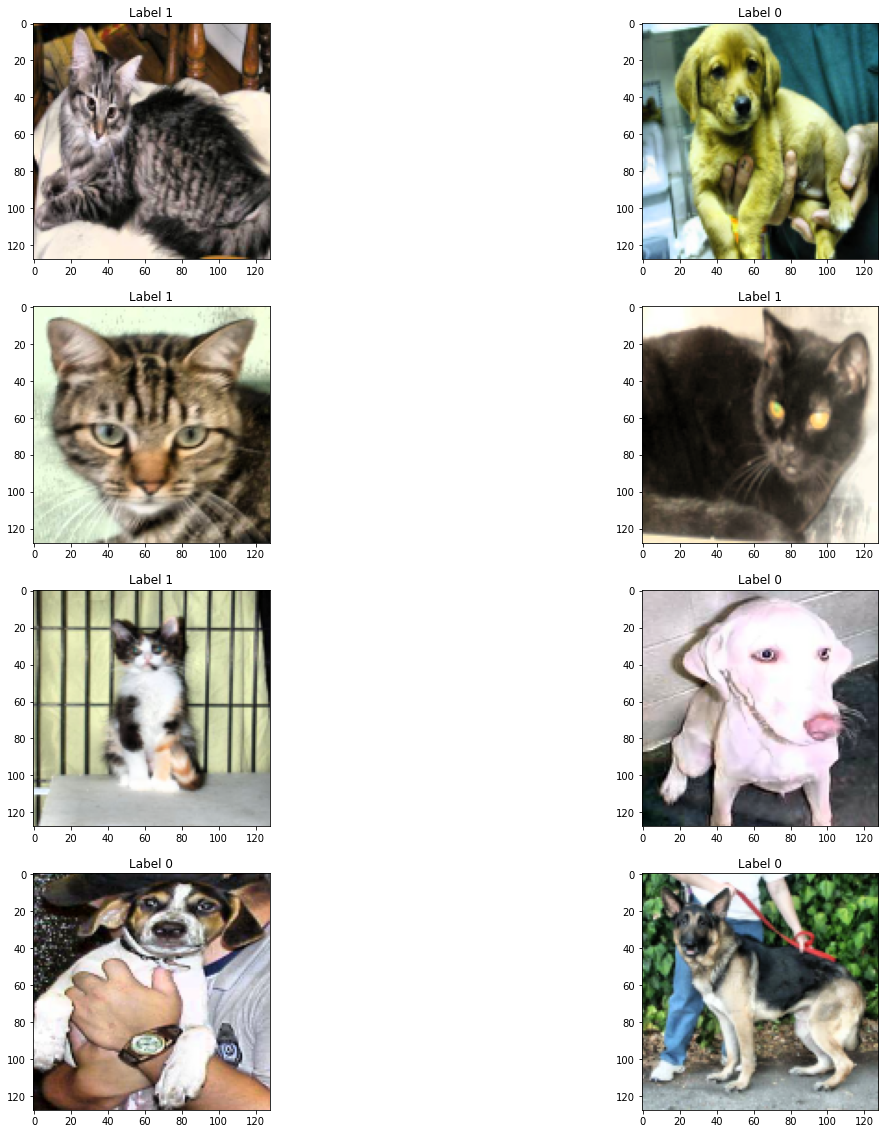

In [3]:
# Visualize a collection of images in the training data
fig, axes = plt.subplots(4, 2, figsize=(20,20))
for i in range(8):
    axes.flatten()[i].imshow(X[i,...,:])
    axes.flatten()[i].set_title('Label ' + str(y[i]))

## Create dataset object
TensorFlow uses Dataset objects to feed data into the training pipeline. These objects were covered in more detail in the TensorFlow Dataset notebook. In this section, we will make a class that builds a dataset object and applies random augmentation operation (e.g. rotation, flipping, scaling).

In [4]:
# Create dataset builder
class DatasetBuilder(object):
    def __init__(self,
                 X,
                 y,
                 batch_size=1,
                 rotation_range=180,
                 scale_range=(0.75, 1.25)):
        self.X = X
        self.y = tf.keras.utils.to_categorical(y)
        
        self.batch_size = batch_size
        self.rotation_range = np.float(rotation_range)
        self.scale_range = scale_range
        
        # Create dataset
        self._create_dataset()
        
    def _augment(self, *args):
        img = args[0]
        label = args[1]
        
        theta = tf.random.uniform([1], 0, 2*np.pi*self.rotation_range/360)
        img = tfa.image.rotate(img, theta)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        return (img, label)
        
    def _create_dataset(self):
        X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(self.X, self.y, train_size=0.8)
        X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size=0.5)
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        
        self.train_dataset = train_dataset.shuffle(256).batch(self.batch_size).map(self._augment)
        self.val_dataset = val_dataset.batch(self.batch_size)
        self.test_dataset = test_dataset.batch(self.batch_size)

In [20]:
db = DatasetBuilder(X, y, batch_size=64)

(64, 128, 128, 3)


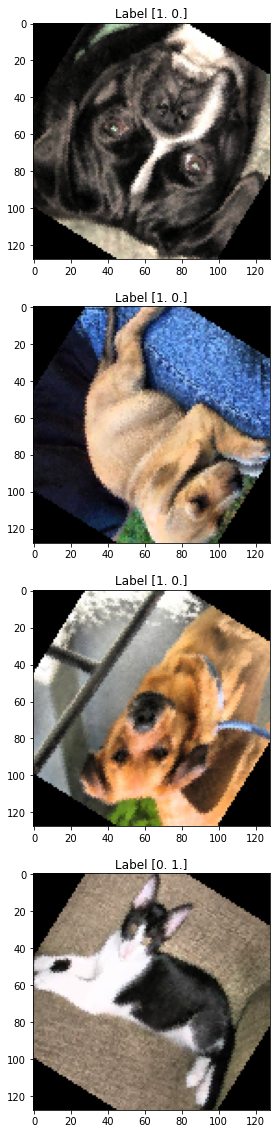

In [6]:
# Check the data augmentation
it = db.train_dataset.as_numpy_iterator()
X_temp, y_temp = it.next()
print(X_temp.shape)

fig, axes = plt.subplots(4, figsize=(20,20))
for i in range(4):
    axes.flatten()[i].imshow(X_temp[i,...,:])
    axes.flatten()[i].set_title('Label ' + str(y_temp[i]))

## Define models
In this section, we will define our machine learning models using TensorFlow. These models are composed of layers - each layer specifies a mathematical operation that is applied to its input. The nice thing about TensorFlow is that almost all of the machinery required for stochastic gradient descent is taken care of for us.
- Specify trainable variables? Check.
- Initialize trainable variables with random values? Check.
- Compute the layer outputs? Check.
- Compute gradients using backpropagation? Check.
- Perform all of the computations on GPUs to speed up training and inference? Check.
All of the above (and more) are taken care of for us by TensorFlow - writing models often requires little math (although one practice that I encourage is keeping track of the input and output dimensions for each layer).

Let define three different models so that we can evaluate their performance on this problem.
- Linear classifier
- Fully connected neural network
- Convolutional neural network (a simple one)

To define these models, we will use a module in TensorFlow called Keras. Keras simple APIs for specifying models. In Keras, there are two different APIs you can use:
- [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) - If your model is composed of a linear sequence of steps, this is the easier API to use.
- [Functional API](https://www.tensorflow.org/guide/keras/functional) - If your model is more complicated, this API provides more flexibility. If you're using the functional API, consider using a class with methods to write submodels.
The TensorFlow documentation provides additional details about how to use each of these two APIs.

In [7]:
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

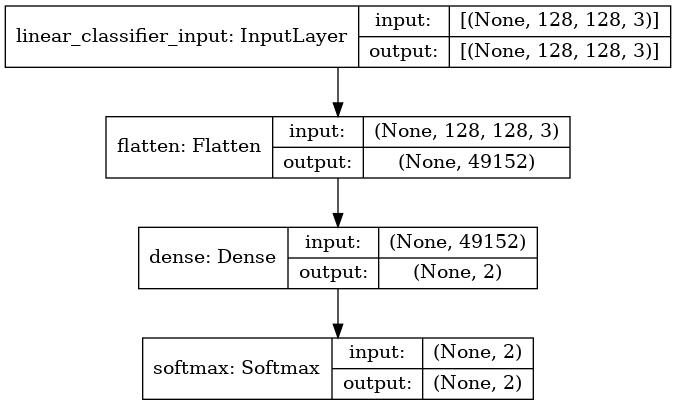

In [8]:
# Define the linear classifier
def create_linear_classifier():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3),
                   name='linear_classifier_input')
    x = Flatten()(inputs)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

linear_classifier = create_linear_classifier()
plot_model(linear_classifier, show_shapes=True)

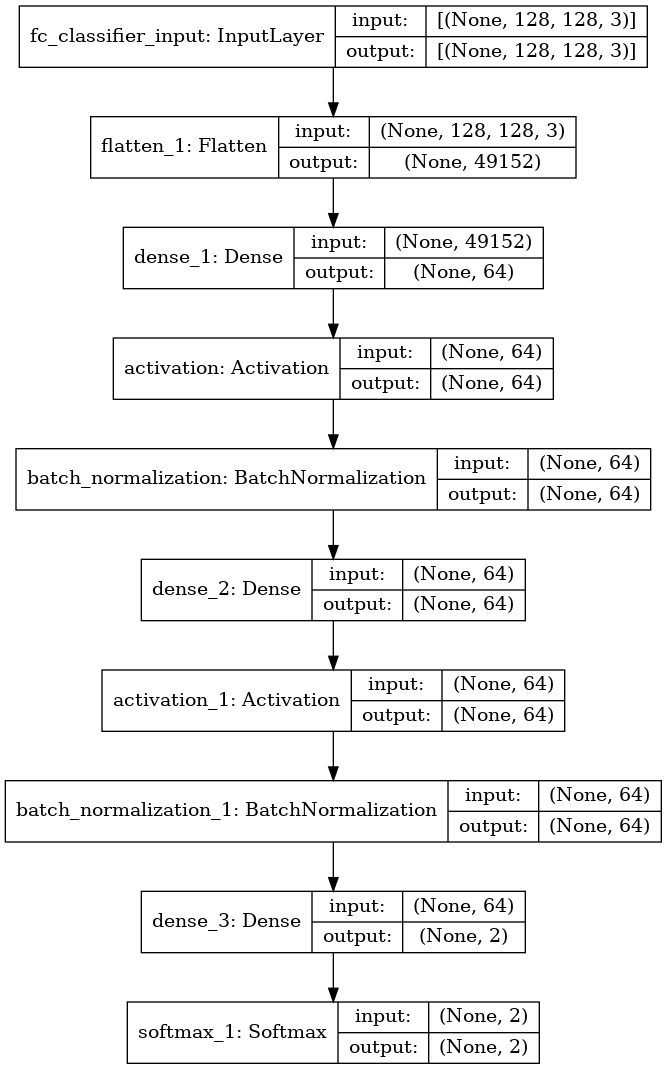

In [9]:
# Define the fully connected neural network
def create_fc_classifier():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3),
                   name='fc_classifier_input')
    x = Flatten()(inputs)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

fc_classifier = create_fc_classifier()
plot_model(fc_classifier, show_shapes=True)

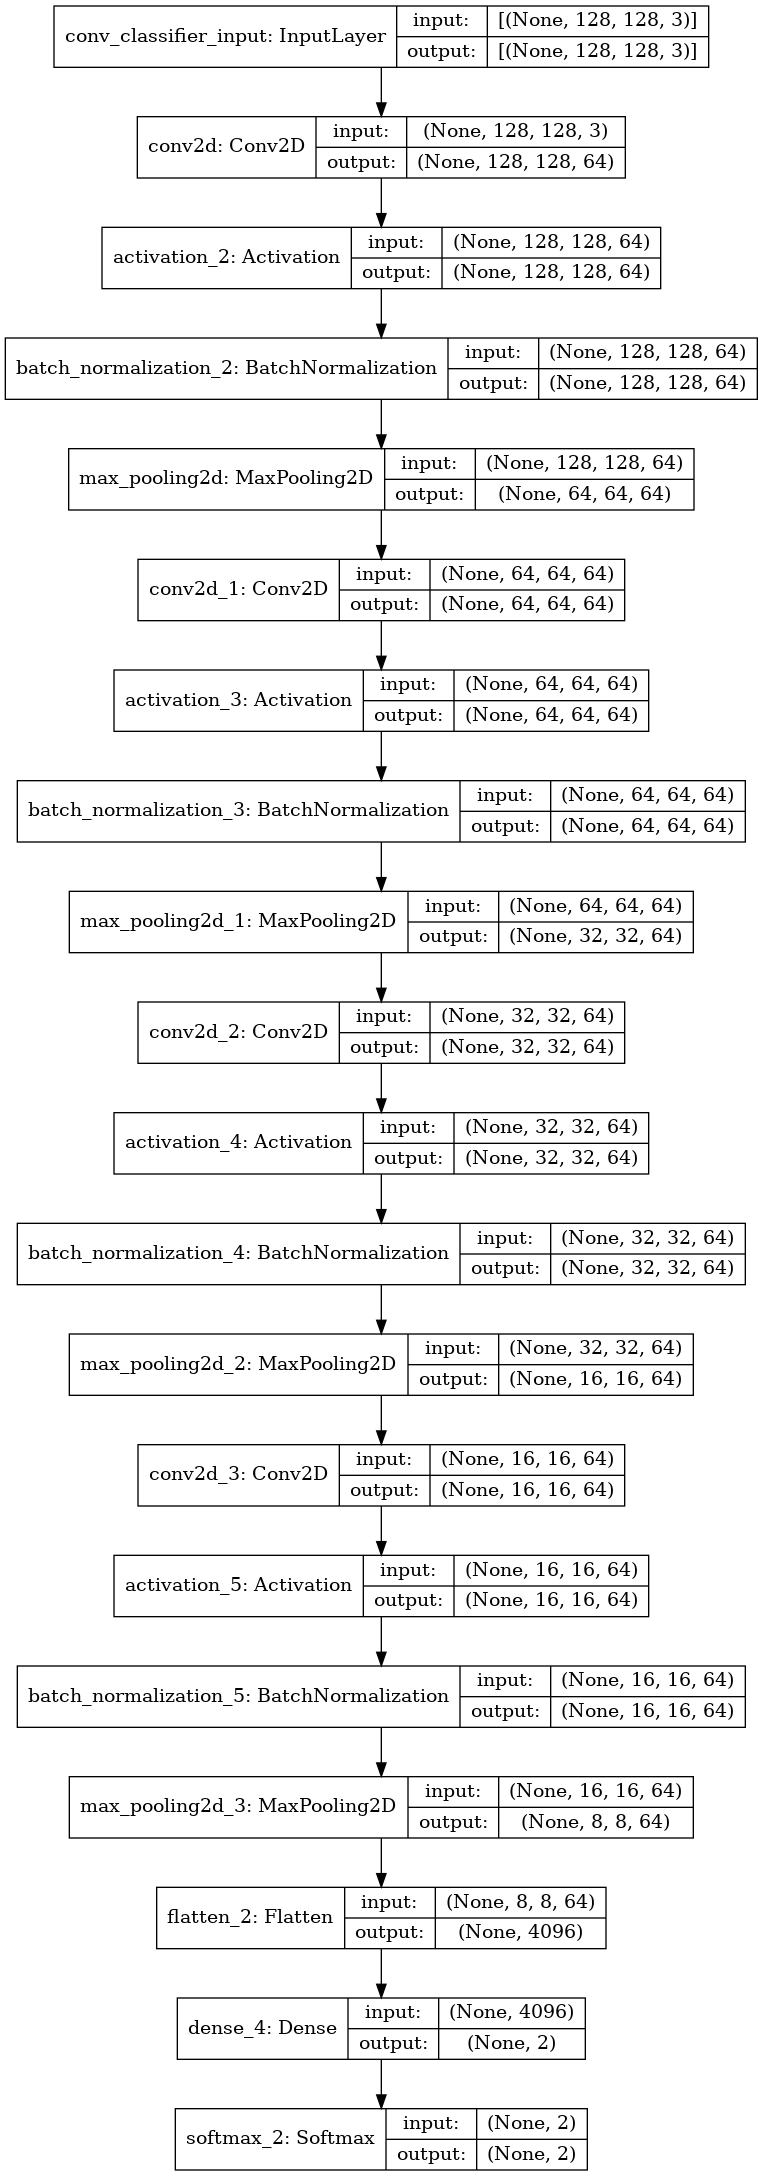

In [10]:
# Define the convolutional neural network
def create_conv_classifier():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3),
                   name='conv_classifier_input')
    x = Conv2D(64, (3,3), padding='SAME')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 16, 16
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 8,8
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 4,4
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 2,2
    x = Flatten()(x)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

conv_classifier = create_conv_classifier()
plot_model(conv_classifier, show_shapes=True)

## Specify training parameters 
In this section, we will specify how we want to train the neural network. We will need to specify three things:
- The loss function. Because we are training a model for classification, we will use the categorical crossentropy
- The training algorithm. There are many flavors of stochastic gradient descent - for this problem, we will use a variant called Adam
- The training parameters. The training algorithm needs parameters like the learning rate, number of epochs, number of steps per epoch, etc. to be specified

In [11]:
# Define the loss function
loss_function = tf.keras.losses.CategoricalCrossentropy() 

In [12]:
# Define the training algorithm
linear_optimizer = tf.keras.optimizers.Adam(lr=1e-3, clipnorm=0.001)
fc_optimizer = tf.keras.optimizers.Adam(lr=1e-3, clipnorm=0.001)
conv_optimizer = tf.keras.optimizers.Adam(lr=1e-3, clipnorm=0.001)

In [13]:
# Define training parameters
training_steps_per_epoch=512
n_epochs=32

# Define callbacks
linear_model_path = '/data/models/bebi205/linear'

linear_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        linear_model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False)
]

linear_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
)

fc_model_path = '/data/models/bebi205/fc'

fc_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        fc_model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False)
]

fc_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
)

conv_model_path = '/data/models/bebi205/conv'

conv_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        conv_model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False)
]

conv_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
)

# Define metrics
recall_0 = tf.keras.metrics.Recall(class_id=0)
recall_1 = tf.keras.metrics.Recall(class_id=1)

precision_0 = tf.keras.metrics.Precision(class_id=0)
precision_1 = tf.keras.metrics.Precision(class_id=1)

In [14]:
# Compile models
linear_classifier.compile(optimizer=linear_optimizer, 
                          loss=loss_function, 
                          metrics = [recall_0, recall_1, precision_0, precision_1])

fc_classifier.compile(optimizer=fc_optimizer, 
                          loss=loss_function, 
                          metrics = [recall_0, recall_1, precision_0, precision_1])

conv_classifier.compile(optimizer=conv_optimizer, 
                          loss=loss_function, 
                          metrics = [recall_0, recall_1, precision_0, precision_1])

## Train the model
With the dataset, model, and training parameters defined, it is straightforward to train a model. Keras Model objects have a fit method that takes in the training parameters and executes the training algorithm.

In [15]:
# Train the linear classifier
linear_classifier.fit(db.train_dataset,
                      validation_data=db.val_dataset,
                      epochs=n_epochs,
                      verbose=1,
                      callbacks=linear_callbacks)

Epoch 1/32
103/103 [==============================] - 17s 152ms/step - loss: 3.7118 - recall: 0.5115 - recall_1: 0.5110 - precision: 0.5148 - precision_1: 0.5070 - val_loss: 1.2333 - val_recall: 0.9257 - val_recall_1: 0.1269 - val_precision: 0.5237 - val_precision_1: 0.6220

Epoch 00001: val_loss improved from inf to 1.23329, saving model to /data/models/bebi205/linear
INFO:tensorflow:Assets written to: /data/models/bebi205/linear/assets
Epoch 2/32
103/103 [==============================] - 15s 146ms/step - loss: 2.9236 - recall: 0.4683 - recall_1: 0.5180 - precision: 0.4985 - precision_1: 0.4876 - val_loss: 1.0794 - val_recall: 0.8321 - val_recall_1: 0.2463 - val_precision: 0.5338 - val_precision_1: 0.5858

Epoch 00002: val_loss improved from 1.23329 to 1.07944, saving model to /data/models/bebi205/linear
INFO:tensorflow:Assets written to: /data/models/bebi205/linear/assets
Epoch 3/32
103/103 [==============================] - 15s 144ms/step - loss: 3.3565 - recall: 0.5535 - recall_1:

In [16]:
# Train the fully connected neural network
fc_classifier.fit(db.train_dataset,
                  validation_data=db.val_dataset,
                  epochs=n_epochs,
                  verbose=1,
                  callbacks=fc_callbacks)

Epoch 1/32
103/103 [==============================] - 17s 149ms/step - loss: 0.8126 - recall: 0.6216 - recall_1: 0.4587 - precision: 0.5419 - precision_1: 0.5409 - val_loss: 2.2140 - val_recall: 0.0000e+00 - val_recall_1: 1.0000 - val_precision: 0.0000e+00 - val_precision_1: 0.4908

Epoch 00001: val_loss improved from inf to 2.21402, saving model to /data/models/bebi205/fc
INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets
Epoch 2/32
103/103 [==============================] - 15s 147ms/step - loss: 0.6989 - recall: 0.6168 - recall_1: 0.5339 - precision: 0.5758 - precision_1: 0.5760 - val_loss: 0.7440 - val_recall: 0.4700 - val_recall_1: 0.5945 - val_precision: 0.5460 - val_precision_1: 0.5196

Epoch 00002: val_loss improved from 2.21402 to 0.74405, saving model to /data/models/bebi205/fc
INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets
Epoch 3/32
103/103 [==============================] - 15s 146ms/step - loss: 0.6844 - recall: 0.6225 - recall_1: 0.5280 

In [24]:
# Train the convolutional neural network
conv_classifier.fit(db.train_dataset,
                    validation_data=db.val_dataset,
                    epochs=n_epochs,
                    verbose=1,
                    callbacks=conv_callbacks)

Epoch 1/32
103/103 [==============================] - 17s 165ms/step - loss: 0.3076 - recall: 0.8679 - recall_1: 0.8671 - precision: 0.8705 - precision_1: 0.8645 - val_loss: 0.3842 - val_recall: 0.7973 - val_recall_1: 0.8619 - val_precision: 0.8263 - val_precision_1: 0.8377

Epoch 00001: val_loss improved from 0.38560 to 0.38423, saving model to /data/models/bebi205/conv
INFO:tensorflow:Assets written to: /data/models/bebi205/conv/assets
Epoch 2/32
103/103 [==============================] - 17s 170ms/step - loss: 0.2913 - recall: 0.8767 - recall_1: 0.8752 - precision: 0.8785 - precision_1: 0.8733 - val_loss: 0.4387 - val_recall: 0.7351 - val_recall_1: 0.8864 - val_precision: 0.8421 - val_precision_1: 0.8024

Epoch 00002: val_loss did not improve from 0.38423
Epoch 3/32
103/103 [==============================] - 17s 167ms/step - loss: 0.2866 - recall: 0.8761 - recall_1: 0.8712 - precision: 0.8750 - precision_1: 0.8722 - val_loss: 0.3759 - val_recall: 0.8216 - val_recall_1: 0.8641 - val_

## Benchmark the model
In this section, we will benchmark each model to assess the performance.

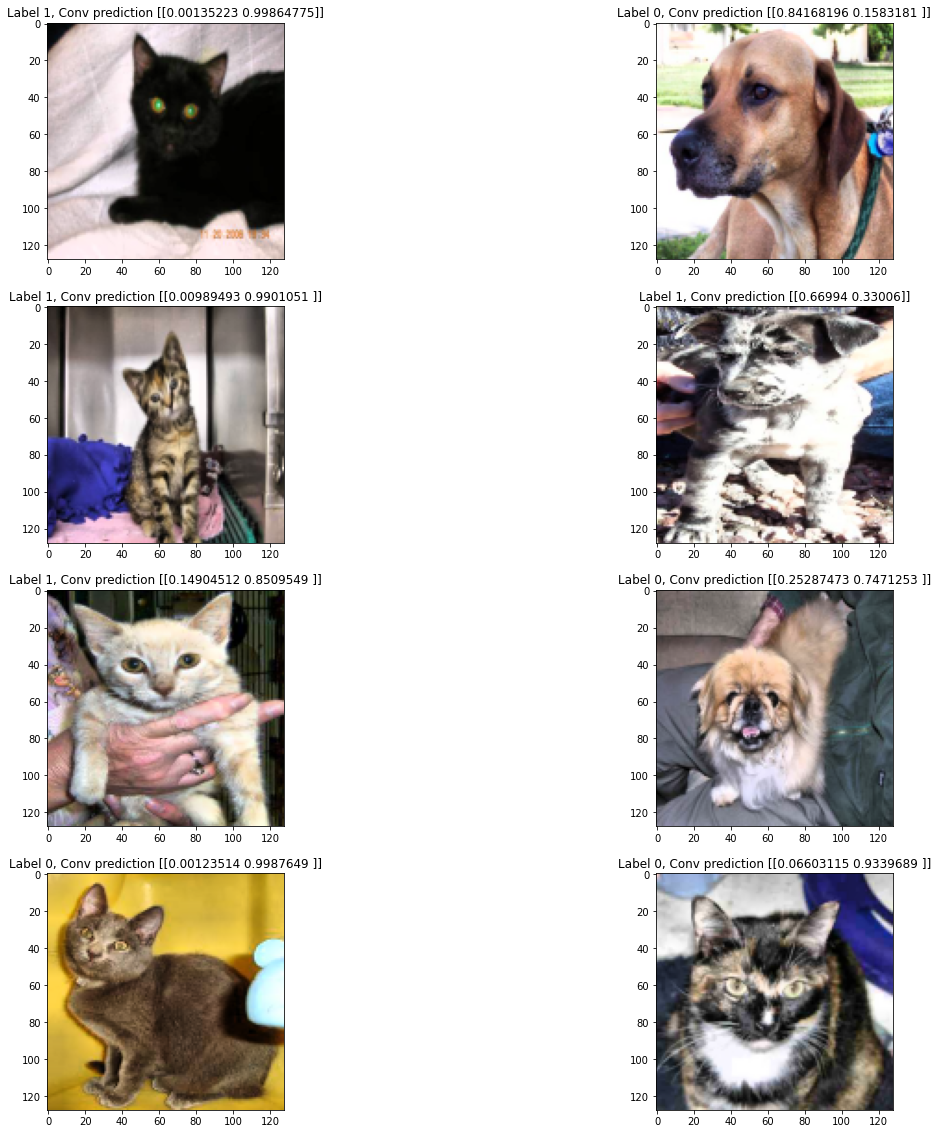

In [25]:
# Visualize some predictions
it = db.test_dataset.as_numpy_iterator()

fig, axes = plt.subplots(4, 2, figsize=(20,20))
for i in range(8):
    X_test, y_test = it.next()
    
    # Get an example image
    X_sample = X_test[[i],...]
    
    # Predict the label
    y_pred_linear = linear_classifier.predict(X_sample)
    y_pred_fc = fc_classifier.predict(X_sample)
    y_pred_conv = conv_classifier.predict(X_sample)
    
    # Display results
    axes.flatten()[i].imshow(X_sample[0])
    axes.flatten()[i].set_title('Label ' + str(y[i]) +', Conv prediction ' + str(y_pred_conv))

In [26]:
# Generate predictions
test_list = list(db.test_dataset.as_numpy_iterator())
X_test = [item[0] for item in test_list]
y_test = [item[1] for item in test_list]

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
y_test = np.argmax(y_test, axis=-1)

# Compute linear classifier metrics
y_pred = linear_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

recall = sklearn.metrics.recall_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)

print('Linear Recall: {}'.format(recall))
print('Linear Precision: {}'.format(precision))
print('Linear F1 Score: {}'.format(f1))

# Compute conv metrics
y_pred = fc_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

recall = sklearn.metrics.recall_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)

print('Fully Connected Recall: {}'.format(recall))
print('Fully Connected Precision: {}'.format(precision))
print('Fully Connected F1 Score: {}'.format(f1))

# Compute conv metrics
y_pred = conv_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

recall = sklearn.metrics.recall_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)

print('Conv Recall: {}'.format(recall))
print('Conv Precision: {}'.format(precision))
print('Conv F1 Score: {}'.format(f1))


Linear Recall: 0.3492822966507177
Linear Precision: 0.6375545851528385
Linear F1 Score: 0.45131375579598143
Fully Connected Recall: 0.35406698564593303
Fully Connected Precision: 0.6851851851851852
Fully Connected F1 Score: 0.4668769716088329
Conv Recall: 0.8899521531100478
Conv Precision: 0.8493150684931506
Conv F1 Score: 0.869158878504673
